# Rectangular Screen Detection (1 of 6).
In this blog post I go trough the process of rectangular screen detection in a photo. This task is part of [my pet project](./0-index.ipynb) where I intend to read the themperature on  thermostat (which is not WiFi enabled)

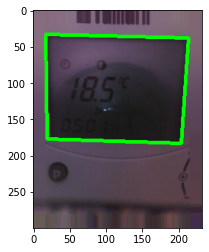

## Imports

In [8]:
# Notebook dependencies
from matplotlib import pyplot as plt

# Algorithm dependencies
import numpy as np
import cv2
# My implementations
from kluppspy.cv import utils as cvu
from kluppspy.devices.esp32 import cam
from kluppspy.devices import thermostat as thm

## Load a Set of Test Photos

First we find all photos of the thermostat contained in a sample folder. This way we can test on more than one image. We print the number of test photos in the folder and show the first sample photo.

Number of available images: 12


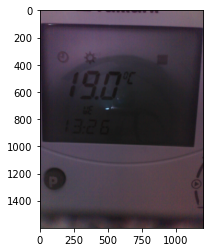

In [9]:
# Test images dir
dir_path = "../images/Kar39Thermostat/"

ims = list(cam.dir_images(dir_path))

print("Number of available images:", len(ims))
im = ims[0]
plt.imshow(im)

## Preprocessing
The first thing we going to do is use a custom preprocessing function that **extends the border** of the image which will put the screen entirely inside the photo. This way the 4 corners of the screen will have **valid coordinates**.

120


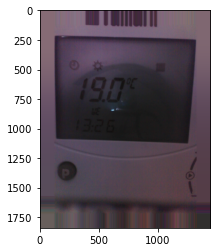

In [18]:
def add_border(im, border_width=None, left_sample_loc=(5, 5), right_sample_loc=(5, -5)):
    """
    Add white border to `Vaillant VRT 300`
    
    add white borders left and right in order to contain the screen inside the picture.
    
    @param im of the thermostat on which the border will be added.
    @param border_width the width of the border to be added.
    @param left_sample_loc sample pixel location for the left border.
    @param right_sample_loc sample pixel location for the right border.
    """
    
    # if the border width is not defined make it one tenth of the width of the picture.
    if border_width is None:
        border_width = int(im.shape[1] / 10)
    
    # We take the samples of the image determined by the sample loc parameters.
    h, w = left_sample_loc
    left_sample = tuple([int(val) for val in im[h, w]])
    
    h, w = right_sample_loc
    right_sample = tuple([int(val) for val in im[h, w]])
    
    
    # Replace the left most and right columns with the sample values (Ensures monotone white color of the end pixels)
    im[0:400, 0:1] = left_sample
    im[0:300, -1:] = right_sample
    
    # We blur the left and right border in order to have smooth transitions. We remove the artificial edges created by the replacement.
    im[0:1450, 0:1] = cv2.blur(im[0:1450, 0:1], (1, 400))
    im[0:1500, -1:] = cv2.blur(im[0:1500, -1:], (1, 400))
    
    # Finally we extend both sides by the number of pixels specified in the border_width
    im = cv2.copyMakeBorder(im, border_width, border_width, border_width, border_width, cv2.BORDER_REPLICATE, None)
    return im, border_width

im_with_border, border_width = add_border(im)
plt.imshow(im_with_border)
print(border_width)

we **scale down** the photo for easier and faster further processing.

Final Image Shape: (300, 234, 3)


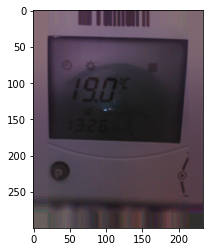

In [21]:
def preprocess_image(im):
    im, border_pixels = add_border(im)
    # Scale down the image so we can find the screen faster (it is big enough)
    ratio = 300.0 / im.shape[0]
    im = cvu.scale_im(im.copy(), ratio)

    return im, ratio, border_pixels

img, _, _ = preprocess_image(im)
plt.imshow(img)
print("Final Image Shape:", img.shape)

## Clean Noise
For this task we use `cv2.bilateralFilter` to remove the noise while still perserving the edges. This is important since we want to find the edge around the screen.

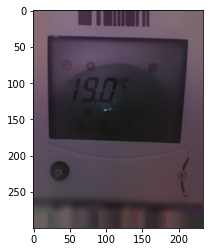

In [22]:
# Blur the image in order to make handle very thin edges
im_blur = cv2.bilateralFilter(img, 11, 17, 200, borderType=cv2.BORDER_REPLICATE)
plt.imshow(im_blur)

## Find Edges
We find edges by using the `Canny` edge detector. The result is presented on the image bellow.

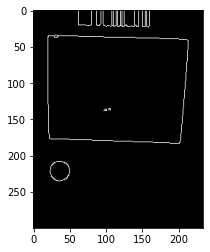

In [23]:
def find_edges(im):
    """
    Find Edges for given BGR image
    """
    # Make the image gray (in this case the colors are not really important 
    # because the screen usually is quite distinctive by brightness only)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    # Blur the image in order to make handle very thin edges
    blur_im = cv2.bilateralFilter(im_gray, 11, 17, 200, borderType=cv2.BORDER_REPLICATE)
    im_edges = cv2.Canny(blur_im, 30, 200)
    return im_edges

im_edges = find_edges(img)
plt.imshow(im_edges, cmap='gray')

## Find Sqare in the Photo

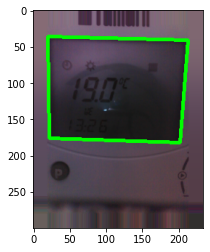

In [24]:
def find_sqare(im):
    
    def approximateContour(cnt):
        peri = cv2.arcLength(cnt, True)
        return np.array(cv2.approxPolyDP(cnt, 0.01 * peri, True))

    im_edges = find_edges(im)
    cnts,_ = cv2.findContours(im_edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = [cv2.convexHull(cnt, False) for cnt in cnts]
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    cnts = [approximateContour(cnt) for cnt in cnts]

    screenCnt = None
    for cnt in cnts:
        # if our approximated contour has four points, then
        # we can assume that we have found our screen
        if len(cnt) == 4:
            screenCnt = cnt
            break

    return screenCnt, cnts

screenCnt, cnts = find_sqare(img)
final_im = img.copy()

# for cnt in cnts:
#     cv2.drawContours(final_im, [cnt], -1, (0, 255, 0), 3) 
    
cv2.drawContours(final_im, [screenCnt], -1, (0, 255, 0), 3) 
plt.imshow(final_im)

## Find Thermostat Screen
here we provide dedicated function for finding the thermostat screen.

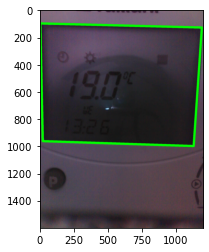

In [7]:
def find_thermostat_screen(im):
    img, scale, border_width = preprocess_image(im)
    screenCnt, cnts = find_sqare(img)
    cnt = thm.invert_changes(screenCnt, scale, border_width)
    cnts = [thm.invert_changes for cnt in cnts]
    return cnt, cnts

screenCnt, cnts = find_thermostat_screen(im)
final_im = im.copy()

# for cnt in cnts:
#     cv2.drawContours(final_im, [cnt], -1, (0, 255, 0), 3) 
cv2.drawContours(final_im, [screenCnt], -1, (0, 255, 0), 15) 

plt.imshow(final_im)

## Test with multiple images
Use `thm.find_screen` from  our library to find the screen

100%|██████████| 12/12 [00:00<00:00, 22.54it/s]


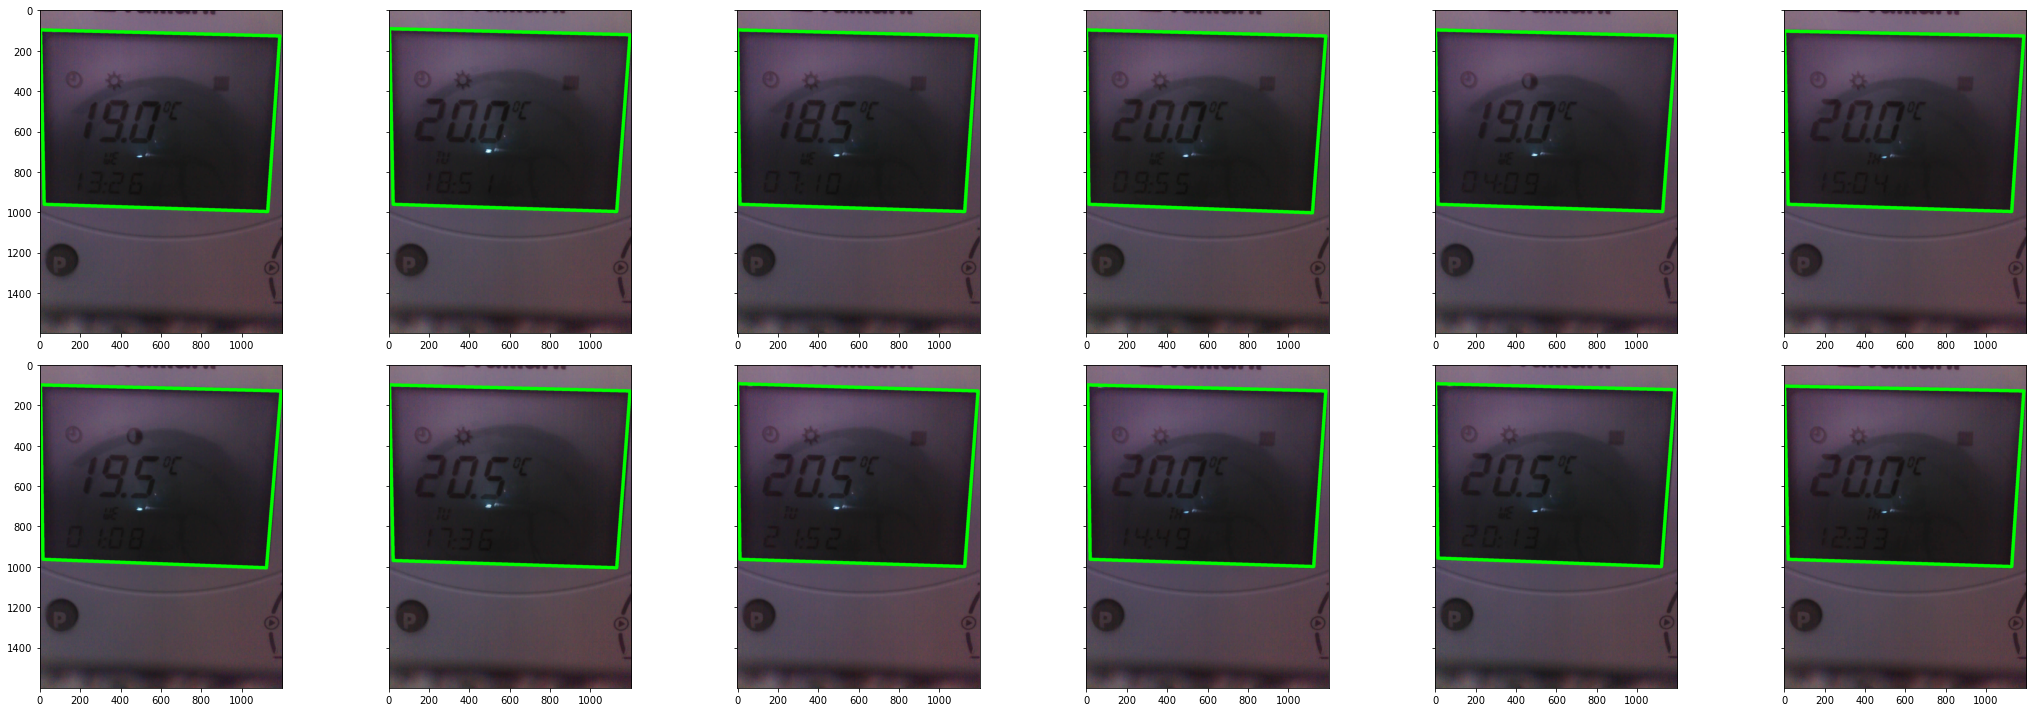

In [9]:
def thermostat_with_wcreen(im):
    screenCnt, cnts = thm.find_screen(im)
    final_im = im.copy()
    cv2.drawContours(final_im, [screenCnt], -1, (0, 255, 0), 15)
    return final_im

cvu.image_test(cam.dir_images, thermostat_with_wcreen, dir_path)